# Project 3: Secret Sharing
Author: James Bui

This notebook compares the runtimes of the computation of numbers using different privacy methods.

In [1]:
from phe import paillier
import random
import time
import numpy as np
import matplotlib.pyplot as plt

### Setting

Set the prime and bit lengths so that Shamir's secret sharing and Paillier have the same security level.

In [2]:
bits_length = 32

n_values = [2, 10, 100, 500, 1_000]

data = {}

prime = 3227029079       

# Generate unique random integers for each n
data = {
    n: random.sample(range(1, n + 1), n)
    for n in n_values
}
    
    

In [3]:
def time_function(func, *args, **kwargs):
    """
    Measures the runtime of a function.

    Parameters:
        func: The function to run
        *args: Positional arguments to pass to func
        **kwargs: Keyword arguments to pass to func

    Returns:
        result: The return value of func
        runtime: Time taken in seconds
    """
    start_time = time.perf_counter()
    result = func(*args, **kwargs)
    end_time = time.perf_counter()
    runtime = end_time - start_time
    return result, runtime

### No privacy protection

In [4]:
def average_with_no_protection(nums):
    return sum(nums) / len(nums)

In [5]:
no_protection_runtimes = []
no_protection_results = []

num_runs = 5  # Number of repeated runs per n

for n in n_values:
    runtimes = []
    results = []

    for _ in range(num_runs):
        result, runtime = time_function(average_with_no_protection, data[n])
        runtimes.append(runtime)
        results.append(result)

    avg_runtime = np.mean(runtimes)
    no_protection_runtimes.append(avg_runtime)
    no_protection_results.append(results[-1])

    print(f"n = {n}")
    print(f"  Average runtime: {avg_runtime:.6f} s")
    print(f"  Last result: {results[-1]}\n")

print("Average runtimes of no privacy protection:", no_protection_runtimes)
print("Results of no privacy protection:", no_protection_results)


n = 2
  Average runtime: 0.000001 s
  Last result: 1.5

n = 10
  Average runtime: 0.000000 s
  Last result: 5.5

n = 100
  Average runtime: 0.000001 s
  Last result: 50.5

n = 500
  Average runtime: 0.000002 s
  Last result: 250.5

n = 1000
  Average runtime: 0.000003 s
  Last result: 500.5

Average runtimes of no privacy protection: [np.float64(5.022040568292141e-07), np.float64(4.4978223741054534e-07), np.float64(5.201902240514755e-07), np.float64(1.8425751477479935e-06), np.float64(3.2990006729960442e-06)]
Results of no privacy protection: [1.5, 5.5, 50.5, 250.5, 500.5]


### The additively homomorphic *Paillier* encryption scheme 

In [6]:
def initialize_keys():
    # Generate public and private keys
    public_key, private_key = paillier.generate_paillier_keypair(n_length=bits_length)
    return public_key, private_key

def encrypt_data(public_key, data):
    # Encrypt a single number
    return public_key.encrypt(data)

def decrypt_data(private_key, data):
    # Encrypt a single number
    return private_key.decrypt(data)

def perform_encrypted_addition(public_key, private_key, nums):
    encrypted_values = []
    # Encrypt numbers
    for num in nums:
        encrypted_num = encrypt_data(public_key, num)
        encrypted_values.append(encrypted_num)
    
    # Add encrypted numbers
    encrypted_sum = sum(encrypted_values) 
    
    # Decrypt sum
    decrypted_sum = private_key.decrypt(encrypted_sum)
    
    avg = decrypted_sum / len(nums)
    return avg

In [7]:
paillier_runtimes = []
paillier_results = []

public_key, private_key = initialize_keys()

num_runs = 5  # Number of repeated runs per n

for n in n_values:
    runtimes = []
    results = []

    for _ in range(num_runs):
        result, runtime = time_function(perform_encrypted_addition, public_key, private_key, data[n])
        runtimes.append(runtime)
        results.append(result)
    
    # Compute average runtime for this n
    avg_runtime = np.mean(runtimes)
    paillier_runtimes.append(avg_runtime)

    # Store the last result
    paillier_results.append(results[-1])
    
    print(f"n = {n}")
    print(f"  Average runtime: {avg_runtime:.6f} s")
    print(f"  Last result: {results[-1]}\n")

print("Average runtime of Paillier privacy protection:", paillier_runtimes)
print("Results of Paillier privacy protection:", paillier_results)


n = 2
  Average runtime: 0.000082 s
  Last result: 1.5

n = 10
  Average runtime: 0.000122 s
  Last result: 5.5

n = 100
  Average runtime: 0.001005 s
  Last result: 50.5

n = 500
  Average runtime: 0.004509 s
  Last result: 250.5

n = 1000
  Average runtime: 0.008785 s
  Last result: 500.5

Average runtime of Paillier privacy protection: [np.float64(8.248219965025782e-05), np.float64(0.00012168202083557844), np.float64(0.0010051270015537738), np.float64(0.004509275418240577), np.float64(0.008784988988190889)]
Results of Paillier privacy protection: [1.5, 5.5, 50.5, 250.5, 500.5]


### Shamir's secret sharing

In [8]:
# Evaluate a polynomial at a given x modulo a prime
def evaluate_polynomial_mod(x, coefficients, prime):
    result = 0
    power = 1
    for coeff in coefficients:
        result = (result + coeff * power) % prime
        power = (power * x) % prime
    return result % prime

def evaluate_polynomial_mod(x, coefficients, prime):
    return sum((coeff * pow(x, i, prime)) % prime for i, coeff in enumerate(coefficients)) % prime


# Generate shares for a secret modulo prime
def generate_shares_mod(secret, num_shares, threshold, prime):
    coefficients = [secret] + [random.randint(1, 1000) for _ in range(threshold - 1)]
    shares = [(x, evaluate_polynomial_mod(x, coefficients, prime)) for x in range(1, num_shares + 1)]
    return shares

# Reconstruct secret from shares using Lagrange interpolation modulo prime
def reconstruct_secret_mod(x_points, y_points, prime):
    num_points = len(x_points)
    secret = 0
    for i in range(num_points):
        numerator = 1
        denominator = 1
        for j in range(num_points):
            if i != j:
                numerator = (numerator * (-x_points[j])) % prime
                denominator = (denominator * (x_points[i] - x_points[j])) % prime
        inv_denominator = pow(denominator, -1, prime)
        secret = (secret + y_points[i] * numerator * inv_denominator) % prime
    return secret

# Compute the average of multiple secrets using Shamir's Secret Sharing
def shamir_secret_sharing(secrets, num_shares, threshold, prime):
    num_secrets = len(secrets)
    
    # Generate shares for each secret
    all_shares = []
    for secret in secrets:
        shares = generate_shares_mod(secret, num_shares, threshold, prime)
        all_shares.append(shares)
    
    # Sum the shares for each party (point-wise)
    summed_shares = []
    for i in range(num_shares):
        x = all_shares[0][i][0]  # same x for all secrets
        y_sum = sum(all_shares[s][i][1] for s in range(num_secrets)) % prime
        summed_shares.append((x, y_sum))
    
    # Reconstruct the sum of secrets using first `threshold` shares
    x_points = [summed_shares[i][0] for i in range(threshold)]
    y_points = [summed_shares[i][1] for i in range(threshold)]
    total_sum = reconstruct_secret_mod(x_points, y_points, prime)
    
    # Compute the average
    average = total_sum / num_secrets
    return average

In [9]:
shamir_runtimes = []
shamir_results = []

num_runs = 5  # Number of repeated runs per n

for n in n_values:
    runtimes = []
    results = []

    for i in range(num_runs):
        result, runtime = time_function(shamir_secret_sharing, data[n], n, n // 2 + 1, prime)
        runtimes.append(runtime)
        results.append(result)

    avg_runtime = np.mean(runtimes)
    shamir_runtimes.append(avg_runtime)
    shamir_results.append(results[-1]) 

    print(f"n = {n}")
    print(f"  Average runtime: {avg_runtime:.6f} s")
    print(f"  Last result: {results[-1]}\n")

print("Average runtimes of Shamir's protection:", shamir_runtimes)
print("Results of Shamir's privacy protection:", shamir_results)


n = 2
  Average runtime: 0.000013 s
  Last result: 1.5

n = 10
  Average runtime: 0.000116 s
  Last result: 5.5

n = 100
  Average runtime: 0.167347 s
  Last result: 50.5

n = 500
  Average runtime: 31.668858 s
  Last result: 250.5

n = 1000
  Average runtime: 290.809108 s
  Last result: 500.5

Average runtimes of Shamir's protection: [np.float64(1.307041384279728e-05), np.float64(0.0001159285893663764), np.float64(0.16734734899364412), np.float64(31.668858111009467), np.float64(290.8091080842074)]
Results of Shamir's privacy protection: [1.5, 5.5, 50.5, 250.5, 500.5]


Plotting the results

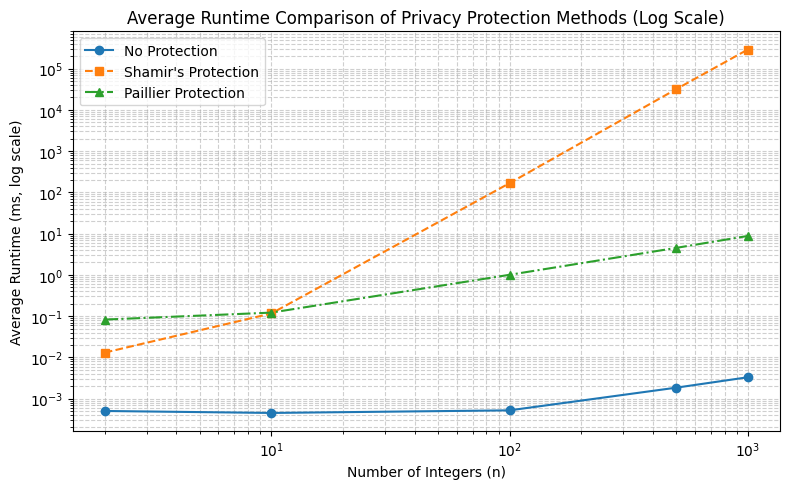

In [10]:
# Convert runtimes to milliseconds
no_protection_runtimes_int = [rt * 1000 for rt in no_protection_runtimes]
shamir_runtimes_int = [rt * 1000 for rt in shamir_runtimes]
paillier_runtimes_int = [rt * 1000 for rt in paillier_runtimes]

# Plot all runtime curves
plt.figure(figsize=(8, 5))

plt.plot(n_values, no_protection_runtimes_int, marker='o', linestyle='-', label='No Protection')
plt.plot(n_values, shamir_runtimes_int, marker='s', linestyle='--', label="Shamir's Protection")
plt.plot(n_values, paillier_runtimes_int, marker='^', linestyle='-.', label='Paillier Protection')

# Apply logarithmic scale to y-axis (runtime)
plt.yscale('log')
# Also make x-axis logarithmic 
plt.xscale('log')

# Labels and formatting
plt.xlabel('Number of Integers (n)')
plt.ylabel('Average Runtime (ms, log scale)')
plt.title('Average Runtime Comparison of Privacy Protection Methods (Log Scale)')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Save first, then show
plt.savefig("comparison_log.png", dpi=300)
plt.show()
